# README

- place data in "data/experiment_set/"

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
from matplotlib.ticker import FuncFormatter
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

# plt.rcParams.update({'font.size': 12})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# format a time delta
def format_func(x, pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)

timedelta_formatter = FuncFormatter(format_func)

In [2]:
sys.path.append('.')

In [3]:
import tools_graph
import tools_data

In [4]:
experiment_set = "data/V1/FREQUENCY_V1"
experiments = tools_data.getExperimentsInSet(experiment_set)

---
# Time Count

In [62]:
def graphMatrixTimeCount(experiment_set, variable, fixed_params_list, subplot_title):
    print(experiment_set)
    index_meaning = {
        0: "Devices",
        1: "Period",
        2: "Messages",
        3: "Subscriptions", 
        4: "Freq Increment Time",
        5: "Freq Increment Step",
        6: "Payload",
        7: "Date",
        8: "Time"
    }
    um = {
        1: "ms",
        6: "Byte",
    }
    
    experiments = tools_data.getExperimentsInSet(experiment_set)
    
    experiments.sort(key = lambda x: int(x.split("_")[variable]))
    base_params = experiments[0].split("_")
    
    ny = math.ceil(len(experiments) / 2)
    nx = 1 if len(experiments) == 1 else 2
    fig, ax = plt.subplots(nrows=ny, ncols=nx, figsize=(3 * ny, 4 * nx))

    def time_count(ax, devices, consumer, title):
        res = pd.DataFrame()
        res["Device"] = devices.resample("1s", on="datetime").count()["datetime"]
        res["Draco"] = consumer.resample("1s", on="datetime").count()["Draco Timestamp"]
        res["Kafka Consumer"] = consumer.resample("1s", on="datetime").count()["Consumer Timestamp"]
        res = res.reset_index()
        res["datetime"] = (res["datetime"] - res["datetime"].min()).apply(lambda x: x) # strfdelta(x, '%H:%M:%S'))

        ax = res["Device"].plot(ax=ax, linewidth=10)
        ax = res["Draco"].plot(ax=ax, linewidth=5)
        ax = res["Kafka Consumer"].plot(ax=ax, linewidth=2)

        ax.set_xlabel("Time")
        ax.set_ylabel("Messages")
        ax.set_title(title)
        ax.xaxis.set_major_formatter(timedelta_formatter)
        # ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
        ax.tick_params(axis='x', rotation=45)
        # plt.xticks(rotation=70)


    i = 0
    for experiment in experiments:
        print(experiment)
        params = experiment.split("_")
        params = [int(p) for p in params]

        consumer = tools_data.readConsumer(experiment_set, experiment)
        device_aggregate = tools_data.readAggregateDevices(experiment_set, experiment)
        time_count(ax[int(i/2)][i%2], device_aggregate, consumer, subplot_title(params))
        i += 1

    
    if len(experiments) < (nx * ny):
        ax.flat[-1].set_visible(False)
    
    i -= 1
    ax[int(i/2)][i%2].legend()
    
    title_string = ""
    for title_index in fixed_params_list:
        title_string += "{} = {}{}, ".format(index_meaning[title_index], base_params[title_index], um[title_index] if title_index in um else "")
    title_string = title_string[:-2]
        
    fig.suptitle(title_string)
    fig.tight_layout()

## Device

data/V1/DEVICE_V1
1_200_4500_1_0_0_1000_20210917_1902
10_200_4500_1_0_0_1000_20210917_1925
25_200_4500_1_0_0_1000_20210917_1949
50_200_4500_1_0_0_1000_20210917_2013
100_200_4500_1_0_0_1000_20210917_2038
125_200_4500_1_0_0_1000_20210917_2105


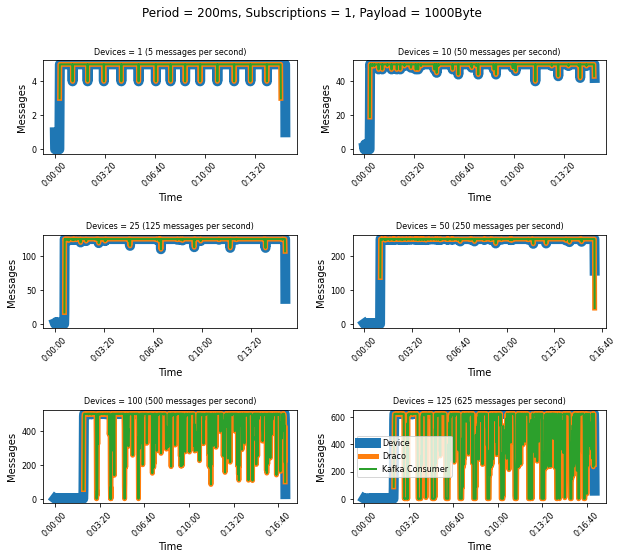

In [67]:
graphMatrixTimeCount("data/V1/DEVICE_V1", 0, [1,3,6], lambda params: "Devices = {} ({} messages per second)".format(params[0], int(params[0]*(1000/params[1])*params[3])))

## Frequency

data/V1/FREQUENCY_V1
5_8_112500_1_0_0_1000_20210917_2332
5_20_45000_1_0_0_1000_20210917_2245
5_40_22500_1_0_0_1000_20210917_2221
5_100_9000_1_0_0_1000_20210917_2157
5_1000_1000_1_0_0_1000_20210917_2132


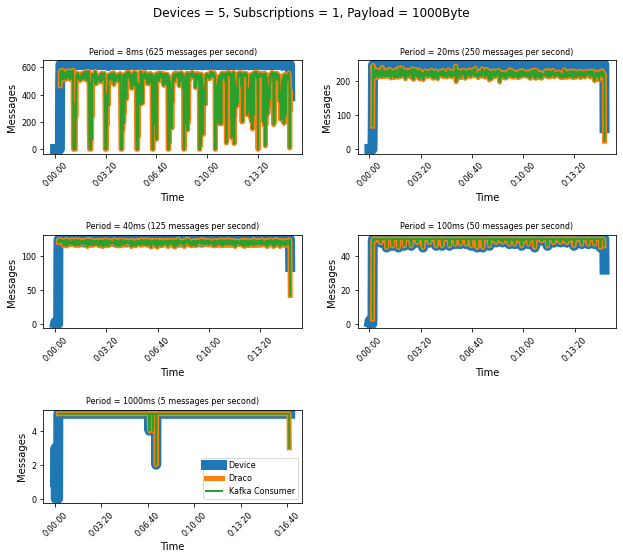

In [65]:
graphMatrixTimeCount("data/V1/FREQUENCY_V1", 1, [0,3,6], lambda params: "Period = {}ms ({} messages per second)".format(params[1], int(params[0]*(1000/params[1])*params[3])))

## Payload

data/V1/PAYLOAD_V1
50_200_4500_1_0_0_1000_20210917_2356
50_200_4500_1_0_0_10000_20210918_0021
50_200_4500_1_0_0_100000_20210918_0046


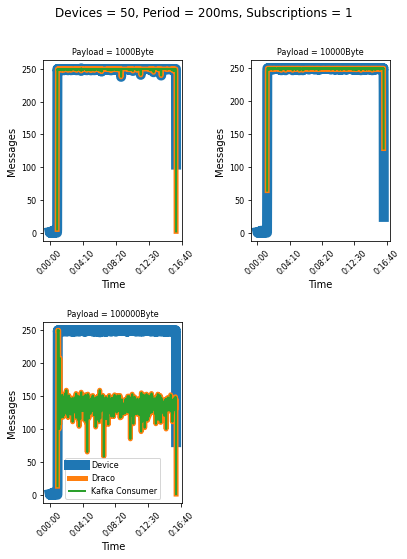

In [69]:
graphMatrixTimeCount("data/V1/PAYLOAD_V1", 6, [0,1,3], lambda params: "Payload = {}Byte".format(params[6]))

## Subscriptions

data/V1/SUB_V1
50_200_4500_1_0_0_1000_20210918_0111
50_200_4500_1_0_0_1000_20210917_2356
50_200_4500_10_0_0_1000_20210918_0137


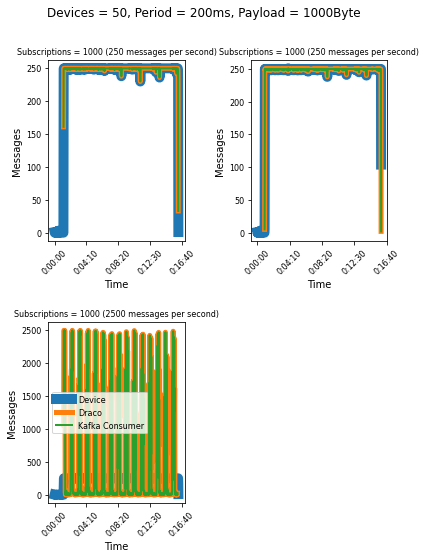

In [71]:
graphMatrixTimeCount("data/V1/SUB_V1", 3, [0,1,6], lambda params: "Subscriptions = {} ({} messages per second)".format(params[6], int(params[0]*(1000/params[1])*params[3])))

---
# Time delay

In [78]:
def graphMatrixTimeDelay(experiment_set, variable, fixed_params_list, subplot_title):
    print(experiment_set)
    index_meaning = {
        0: "Devices",
        1: "Period",
        2: "Messages",
        3: "Subscriptions", 
        4: "Freq Increment Time",
        5: "Freq Increment Step",
        6: "Payload",
        7: "Date",
        8: "Time"
    }
    um = {
        1: "ms",
        6: "Byte",
    }
    
    experiments = tools_data.getExperimentsInSet(experiment_set)
    
    experiments.sort(key = lambda x: int(x.split("_")[variable]))
    base_params = experiments[0].split("_")
    
    ny = math.ceil(len(experiments) / 2)
    nx = 1 if len(experiments) == 1 else 2
    fig, ax = plt.subplots(nrows=ny, ncols=nx, figsize=(3 * ny, 4 * nx))

    def time_delay(ax, consumer, title):
        delayDracoDevice = consumer.resample("1s", on='datetime').mean()["Delay Draco/Device"]
        delayKafkaDraco = consumer.resample("1s", on='datetime').mean()["Delay Kafka/Draco"]
        delayKafkaConsumer = consumer.resample("1s", on='datetime').mean()["Delay Kafka Consumer"]

        res = pd.DataFrame()
        res["Draco"] = delayDracoDevice
        res["Kafka/Draco"] = delayKafkaDraco
        res["Kafka Consumer"] = delayKafkaConsumer
        res = res.reset_index()
        res["datetime"] = (res["datetime"] - res["datetime"].min()).apply(lambda x: x) # strfdelta(x, '%H:%M:%S'))

        ax = res["Draco"].plot(ax=ax, linewidth=10)
        ax = res["Kafka/Draco"].plot(ax=ax, linewidth=5)
        ax = res["Kafka Consumer"].plot(ax=ax, linewidth=2)

        ax.set_xlabel("Time")
        ax.set_ylabel("Delay (ms)")
        ax.set_title(title)
        ax.xaxis.set_major_formatter(timedelta_formatter)
        ax.tick_params(axis='x', rotation=45)


    i = 0
    for experiment in experiments:
        print(experiment)
        params = experiment.split("_")
        params = [int(p) for p in params]

        consumer = tools_data.readConsumer(experiment_set, experiment)
        time_delay(ax[int(i/2)][i%2], consumer, subplot_title(params))
        i += 1

    
    if len(experiments) < (nx * ny):
        ax.flat[-1].set_visible(False)
    
    i -= 1
    ax[int(i/2)][i%2].legend()
    
    title_string = ""
    for title_index in fixed_params_list:
        title_string += "{} = {}{}, ".format(index_meaning[title_index], base_params[title_index], um[title_index] if title_index in um else "")
    title_string = title_string[:-2]
        
    fig.suptitle(title_string)
    fig.tight_layout()

## Device

data/V1/DEVICE_V1
1_200_4500_1_0_0_1000_20210917_1902
10_200_4500_1_0_0_1000_20210917_1925
25_200_4500_1_0_0_1000_20210917_1949
50_200_4500_1_0_0_1000_20210917_2013
100_200_4500_1_0_0_1000_20210917_2038
125_200_4500_1_0_0_1000_20210917_2105


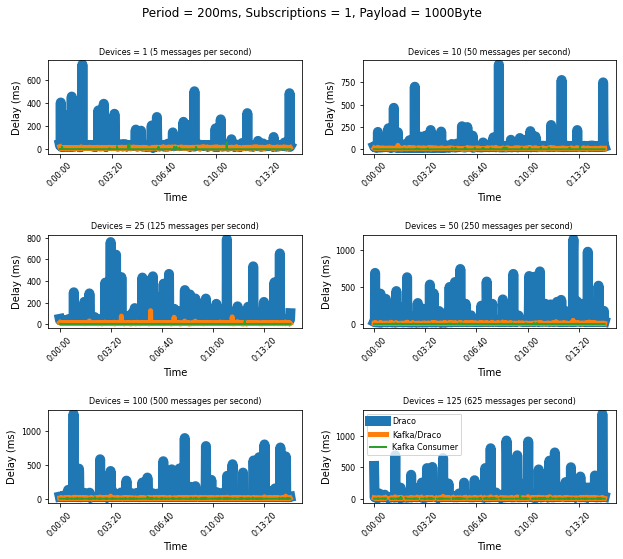

In [79]:
graphMatrixTimeDelay("data/V1/DEVICE_V1", 0, [1,3,6], lambda params: "Devices = {} ({} messages per second)".format(params[0], int(params[0]*(1000/params[1])*params[3])))

## Frequency

data/V1/FREQUENCY_V1
5_8_112500_1_0_0_1000_20210917_2332
5_20_45000_1_0_0_1000_20210917_2245
5_40_22500_1_0_0_1000_20210917_2221
5_100_9000_1_0_0_1000_20210917_2157
5_1000_1000_1_0_0_1000_20210917_2132


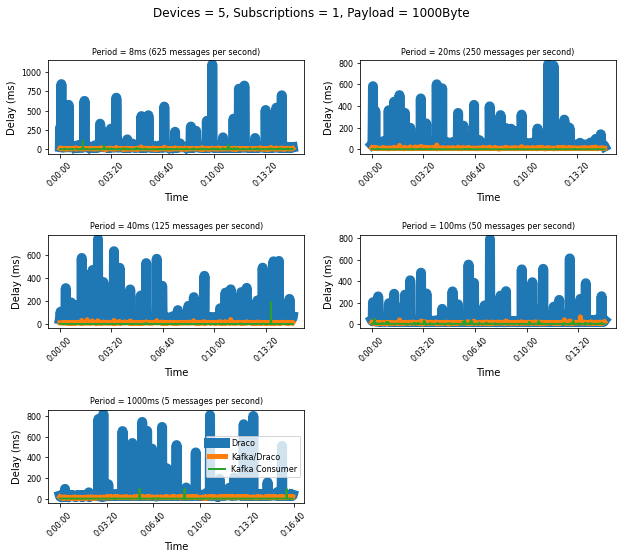

In [80]:
graphMatrixTimeDelay("data/V1/FREQUENCY_V1", 1, [0,3,6], lambda params: "Period = {}ms ({} messages per second)".format(params[1], int(params[0]*(1000/params[1])*params[3])))

## Payload

data/V1/PAYLOAD_V1
50_200_4500_1_0_0_1000_20210917_2356
50_200_4500_1_0_0_10000_20210918_0021
50_200_4500_1_0_0_100000_20210918_0046


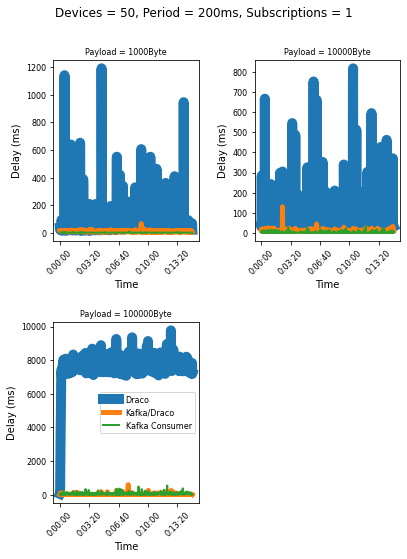

In [82]:
graphMatrixTimeDelay("data/V1/PAYLOAD_V1", 6, [0,1,3], lambda params: "Payload = {}Byte".format(params[6]))

## Subscriptions

data/V1/SUB_V1
50_200_4500_1_0_0_1000_20210918_0111
50_200_4500_1_0_0_1000_20210917_2356
50_200_4500_10_0_0_1000_20210918_0137


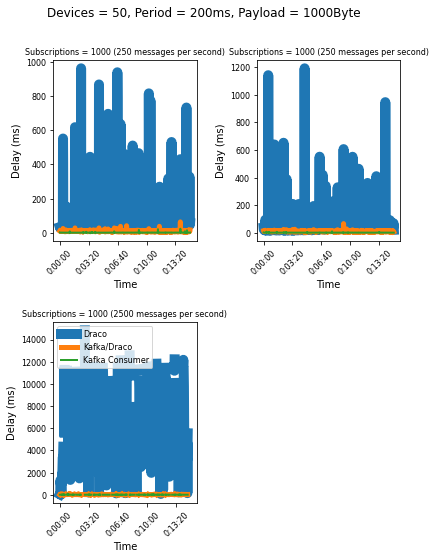

In [84]:
graphMatrixTimeDelay("data/V1/SUB_V1", 3, [0,1,6], lambda params: "Subscriptions = {} ({} messages per second)".format(params[6], int(params[0]*(1000/params[1])*params[3])))

---
# Cumulative

In [99]:
def cumulative(experiment_set, xlabel, ylabel, mapper, mapper2):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
    metrics = {}
    experiments = os.listdir(experiment_set)
    for experiment in experiments:
        consumer = tools_data.readConsumer(experiment_set, experiment) # read consumer data
        devices = tools_data.readAggregateDevices(experiment_set, experiment) # read data from devices, the two can differ due to message loss
        params = experiment.split("_")
        label = mapper(params)
        metrics[label] = mapper2(consumer, devices)
       
    result = pd.DataFrame.from_dict(metrics, orient="index")
    result.index = result.index.astype(float)
    result = result.sort_index()  
    
    ax = result.plot(ax=ax, kind="bar", legend=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels([int(x) for x in sorted(list(metrics.keys()))])
    fig.tight_layout()
    #return fig

In [100]:
l =  lambda params: int(params[0]) * (1000/int(params[1]) * int(params[3]))

## Frequency

['5', '1000', '1000', '1', '0', '0', '1000', '20210917', '2132']
['5', '100', '9000', '1', '0', '0', '1000', '20210917', '2157']
['5', '20', '45000', '1', '0', '0', '1000', '20210917', '2245']
['5', '40', '22500', '1', '0', '0', '1000', '20210917', '2221']
['5', '8', '112500', '1', '0', '0', '1000', '20210917', '2332']


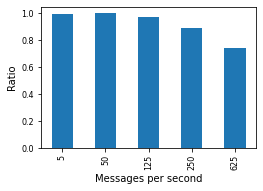

In [101]:
cumulative("data/V1/FREQUENCY_V1", "Messages per second", "Ratio", l, lambda consumer, devices: consumer.shape[0] / devices.shape[0])

['5', '1000', '1000', '1', '0', '0', '1000', '20210917', '2132']
['5', '100', '9000', '1', '0', '0', '1000', '20210917', '2157']
['5', '20', '45000', '1', '0', '0', '1000', '20210917', '2245']
['5', '40', '22500', '1', '0', '0', '1000', '20210917', '2221']
['5', '8', '112500', '1', '0', '0', '1000', '20210917', '2332']


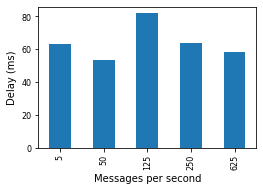

In [102]:
cumulative("data/V1/FREQUENCY_V1", "Messages per second", "Delay (ms)", l, lambda consumer, devices: consumer["Delay Consumer/Device"].mean())

## Devices

['100', '200', '4500', '1', '0', '0', '1000', '20210917', '2038']
['10', '200', '4500', '1', '0', '0', '1000', '20210917', '1925']
['125', '200', '4500', '1', '0', '0', '1000', '20210917', '2105']
['1', '200', '4500', '1', '0', '0', '1000', '20210917', '1902']
['25', '200', '4500', '1', '0', '0', '1000', '20210917', '1949']
['50', '200', '4500', '1', '0', '0', '1000', '20210917', '2013']


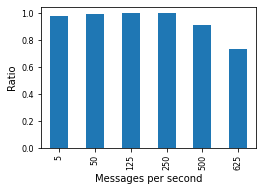

In [103]:
cumulative("data/V1/DEVICE_V1", "Messages per second", "Ratio", l, lambda consumer, devices: consumer.shape[0] / devices.shape[0])

['100', '200', '4500', '1', '0', '0', '1000', '20210917', '2038']
['10', '200', '4500', '1', '0', '0', '1000', '20210917', '1925']
['125', '200', '4500', '1', '0', '0', '1000', '20210917', '2105']
['1', '200', '4500', '1', '0', '0', '1000', '20210917', '1902']
['25', '200', '4500', '1', '0', '0', '1000', '20210917', '1949']
['50', '200', '4500', '1', '0', '0', '1000', '20210917', '2013']


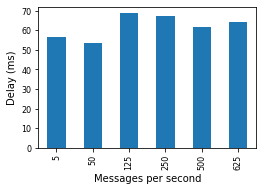

In [104]:
cumulative("data/V1/DEVICE_V1", "Messages per second", "Delay (ms)", l, lambda consumer, devices: consumer["Delay Consumer/Device"].mean())

## Subscriptions

['50', '200', '4500', '10', '0', '0', '1000', '20210918', '0137']
['50', '200', '4500', '1', '0', '0', '1000', '20210917', '2356']
['50', '200', '4500', '1', '0', '0', '1000', '20210918', '0111']


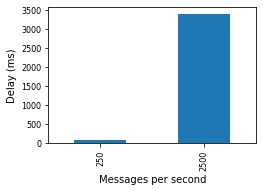

In [105]:
cumulative("data/V1/SUB_V1", "Messages per second", "Delay (ms)", l, lambda consumer, devices: consumer["Delay Consumer/Device"].mean())

['50', '200', '4500', '10', '0', '0', '1000', '20210918', '0137']
['50', '200', '4500', '1', '0', '0', '1000', '20210917', '2356']
['50', '200', '4500', '1', '0', '0', '1000', '20210918', '0111']


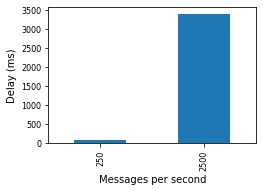

In [106]:
cumulative("data/V1/SUB_V1", "Messages per second", "Delay (ms)", l, lambda consumer, devices: consumer["Delay Consumer/Device"].mean())

## Payloadd

['50', '200', '4500', '1', '0', '0', '100000', '20210918', '0046']
['50', '200', '4500', '1', '0', '0', '10000', '20210918', '0021']
['50', '200', '4500', '1', '0', '0', '1000', '20210917', '2356']


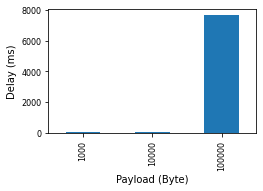

In [109]:
cumulative("data/V1/PAYLOAD_V1", "Payload (Byte)", "Delay (ms)", lambda params: params[6], lambda consumer, devices: consumer["Delay Consumer/Device"].mean())

['50', '200', '4500', '1', '0', '0', '100000', '20210918', '0046']
['50', '200', '4500', '1', '0', '0', '10000', '20210918', '0021']
['50', '200', '4500', '1', '0', '0', '1000', '20210917', '2356']


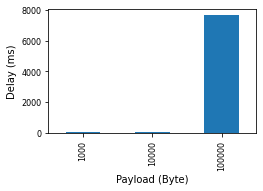

In [110]:
cumulative("data/V1/PAYLOAD_V1", "Payload (Byte)", "Delay (ms)", lambda params: params[6], lambda consumer, devices: consumer["Delay Consumer/Device"].mean())